In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def Traffic(n, vmax_lorries, vmax_cars, vmax_bikes, density, percent_lorries, percent_bikes, prob_car_daw, blockage, max_iterations, road_type, dis_type, display):
    ''' Function to generate a road and while cars are generated and move according to a set of rules.
        Inputs:
        n = length of the road
        vmax = max speed of the cars
        density = density of cars on the road
        prob_car_daw = probability of the cars dawdeling
        blockage = fraction of the road at which the lane closure occurs
        max_iterations = number of timesteps
        road_type
        dis_type
        display
    ''' 
    #adding one to vmax magnitudes to account for element = speed+1 
    vmax_lorries+=1
    vmax_cars+=1
    vmax_bikes+=1
        
    if road_type == 'Multi':
        no_lanes = 3
    else:
        no_lanes = 1
    tol = 1e-4
    #Create empty road and matrix to store iterations
    if abs(no_lanes -3 )<tol:
        tripleroad = np.zeros((no_lanes,n), dtype = complex)
    else:
        road = np.zeros(n)
    if abs(no_lanes -3 )<tol:
        matrix = np.zeros(((no_lanes+1)*(max_iterations-1) -1 , n))
        tripledata= np.zeros((no_lanes*max_iterations, 9))
    else:
        matrix = np.zeros((max_iterations, n))
        data= np.zeros((max_iterations, 5))
    iterations = 0
    
    #road closure
    #tripleroad[0, int(n*0.6):int(n)] = 1+2j
    
    ### Car Generation ###
    if abs(no_lanes -3 )<tol:
        for j in range(no_lanes):
            for i in range(round(n*density)):
                ranspace = np.random.randint(0, n)
                while tripleroad[j,ranspace]!=0:
                    ranspace = np.random.randint(0, n)
                if np.random.randint(1, 100)<percent_lorries*100 and no_lanes - 1 <2:  
                    tripleroad[j, ranspace]=np.random.randint(2, vmax_lorries) -1j
                elif np.random.randint(1, 100)<percent_bikes*200:
                    tripleroad[j, ranspace]=np.random.randint(2, vmax_bikes) +1j
                else:
                    tripleroad[j, ranspace]=np.random.randint(2, vmax_cars)
    
    else:
        for i in range(round(n*density)):
            ranspace = np.random.randint(0, n)
            while road[ranspace]!=0:
                ranspace = np.random.randint(0, n)
            road[ranspace]=np.random.randint(2, vmax_cars)                                  
                                       
    while iterations in range(max_iterations):
        
       
        if abs(no_lanes -3) <tol:                              
            #create loop like extention to the end of the road
            leftlane = np.concatenate((tripleroad[0,], tripleroad[0,]))
            middlelane = np.concatenate((tripleroad[1,], tripleroad[1,]))
            rightlane = np.concatenate((tripleroad[2,], tripleroad[2,]))

            for i in range(n-vmax_bikes, -1, -1):

                #setting the max speed depending on vehicle type
                if leftlane[i].imag == -1:
                    vmax = vmax_lorries
                elif leftlane[i].imag == 1:
                    vmax = vmax_bikes
                else:
                    vmax = vmax_cars

                #for the middle lane
                if middlelane[i].imag == -1:
                    vmax = vmax_lorries
                elif middlelane[i].imag == 1:
                    vmax = vmax_bikes
                else:
                    vmax = vmax_cars

                #for the right lane
                if rightlane[i].imag == -1:
                    vmax = vmax_lorries
                elif rightlane[i].imag == 1:
                    vmax = vmax_bikes
                else:
                    vmax = vmax_cars


                ### Overtaking ###

                #cars in the left lane:
                if leftlane[i].real>1 and abs(leftlane[i].imag-2)>tol :
                    #space in the middle lane for it to move forward into
                    if middlelane[i].real==0:
                        # are there cars in front?
                        if sum(leftlane[i+1:i+int(leftlane[i].real)].real)!=0:
                            #is it worth overtaking, the cars ahead:
                            count = 0    #Count is the distance between two cars.
                            while leftlane[i + count+1].real<1 and count<vmax:
                                count+=1
                            #if the velocity of the car is greater than the distance between
                            if  leftlane[i].real>count: 
                                #if the speed of the car is slowe than its max
                                if leftlane[i].real< vmax: #leftlane[i + count+1].real: 
                                    #ensure we stay within index- this will not matter when we move to periodic system
                                    if i-vmax>0:
                                        #ensuring the car behind in the middle lane wont have to slow down
                                        count2 = 0 
                                        while middlelane[i - count2 - 1].real<1 and count2<vmax:
                                            count2+=1
                                        #if the speed (1 timestep) of car behind is smaller than the distance
                                        if middlelane[[i - count2-1]].real<count2:

                                            #ensuring the car won't have to slow down in the middle lane
                                            count3 = 0 
                                            while middlelane[i + count3+1].real<1 and count3<=vmax:
                                                count3+=1

                                            #no cars infront at distance equivalent to that will be travelled in one time step.
                                            if  leftlane[i].real<count3:
                                                leftlane[i]+=1
                                                #move into the middle lane
                                                middlelane = np.delete(middlelane, i)
                                                middlelane = np.insert(middlelane, i, leftlane[i])

                                                leftlane = np.delete(leftlane, i)
                                                leftlane = np.insert(leftlane, i, 0)

                                                if middlelane[i]<vmax:
                                                    middlelane[i]+=1

                                            #if the cars that are in front are faster
                                            elif leftlane[i].real<middlelane[i + count3+1].real:
                                                #move into the middle lane
                                                middlelane = np.delete(middlelane, i)
                                                middlelane = np.insert(middlelane, i, leftlane[i])

                                                leftlane = np.delete(leftlane, i)
                                                leftlane = np.insert(leftlane, i, 0)

                                                if middlelane[i]<vmax:
                                                    middlelane[i]+=1

                ### Moving to the slower lane ###

                #cars in the right lane:
                if rightlane[i].real>1 and abs(rightlane[i].imag-2)>tol:
                    #space in the middle lane for it to move forward into
                    if middlelane[i].real==0:

                        #if cars in the middle lane ahead are traveling at the same speed or faster
                        count4=0 
                        while middlelane[i + count4+1].real<1 and count4<=vmax:
                            count4+=1
                        #no cars in that space
                        if  rightlane[i].real<=count4:

                            #move into the middle lane
                            middlelane = np.delete(middlelane, i)
                            middlelane = np.insert(middlelane, i, rightlane[i])                                          

                            rightlane = np.delete(rightlane, i)
                            rightlane = np.insert(rightlane, i, 0)

                        #the car is traveling slower or equal than the cars in the space 
                        #and will have the distance between to not have to slow down
                        elif rightlane[i].real<=middlelane[i + count4+1].real:

                            #move into the middle lane
                            middlelane = np.delete(middlelane, i)
                            middlelane = np.insert(middlelane, i, rightlane[i])                                          

                            rightlane = np.delete(rightlane, i)
                            rightlane = np.insert(rightlane, i, 0)


                ### cars in the middle lane can overtake or go into the slower lane
                ### Overtaking ###

                #cars in the middle lane:
                if middlelane[i].real>1 and abs(middlelane[i].imag-2)>tol:
                    #space in the right lane for it to move forward into
                    if rightlane[i].real==0:
                        # are there cars in front?
                        if sum(middlelane[i+1:i+int(middlelane[i].real)].real)!=0:
                            #is it worth overtaking, the cars ahead:
                            count = 0    #Count is the distance between two cars.
                            while middlelane[i + count+1].real<1 and count<vmax:
                                count+=1
                            #if the velocity of the car is greater than the distance between
                            if  middlelane[i].real>count: 
                                #if the speed of the car is slower than it's max
                                if middlelane[i].real< vmax: #middlelane[i + count+1].real: 
                                    #ensure we stay within index- this will not matter when we move to periodic system
                                    if i-vmax>0:
                                        #ensuring the car behind in the right lane wont have to slow down
                                        count2 = 0 
                                        while rightlane[i - count2 - 1].real<1 and count2<vmax:
                                            count2+=1
                                        #if the speed (1 timestep) of car behind is smaller than the distance
                                        if rightlane[[i - count2-1]].real<count2:
                                            #ensuring the car won't have to slow down in the right lane
                                            count3 = 0 
                                            while rightlane[i + count3+1].real<1 and count3<=vmax:
                                                count3+=1
                                            #no cars infront at distance equivalent to that will be travelled in one time step.
                                            if  middlelane[i].real<count3:
                                                #move into the right lane
                                                rightlane = np.delete(rightlane, i)
                                                rightlane = np.insert(rightlane, i, middlelane[i])

                                                middlelane = np.delete(middlelane, i)
                                                middlelane = np.insert(middlelane, i, 0)

                                                if rightlane[i]<vmax:
                                                    rightlane[i]+=1

                                            #if the cars that are in front are faster
                                            elif middlelane[i].real<rightlane[i + count3+1].real:

                                                #move into the right lane
                                                rightlane = np.delete(rightlane, i)
                                                rightlane = np.insert(rightlane, i, middlelane[i])

                                                middlelane = np.delete(middlelane, i)
                                                middleane = np.insert(middlelane, i, 0)

                                                if rightlane[i]<vmax:
                                                    rightlane[i]+=1

                ### Moving to the slower lane ###

                #cars in the middle lane:
                if middlelane[i].real>1 and abs(middlelane[i].imag-2)>tol:
                    #space in the left lane for it to move forward into
                    if leftlane[i].real==0:
                        #if cars in the left lane ahead are traveling at the same speed or faster
                        count4=0 
                        while leftlane[i + count4+1].real<1 and count4<=vmax:
                            count4+=1
                        #no cars in that space
                        if  middlelane[i].real<=count4:

                            #move into the other lane
                            leftlane = np.delete(leftlane, i)
                            leftlane = np.insert(leftlane, i, middlelane[i])                                          

                            middlelane = np.delete(middlelane, i)
                            middlelane = np.insert(middlelane, i, 0)
                            
                        #the car is traveling slower or equal than the cars in the space 
                        #and will have the distance between to not have to slow down
                        elif middlelane[i].real<=leftlane[i + count4+1].real:

                            #move into the other lane
                            leftlane = np.delete(leftlane, i)
                            leftlane = np.insert(leftlane, i, middlelane[i])                                          

                            middlelane = np.delete(middlelane, i)
                            middlelane = np.insert(middlelane, i, 0)

            #reducing each lane to its oringial size and back into the one road containing each lane.
            #It was important to double the size of the road so that the objects we are taking into consideration when 
            #checking cars forward and behind, dont exceed the limits of the array
            tripleroad[0,] = np.concatenate((leftlane[n:n+int(n/2)], leftlane[int(n/2):n]))
            tripleroad[1,] = np.concatenate((middlelane[n:n+int(n/2)], middlelane[int(n/2):n]))
            tripleroad[2,] = np.concatenate((rightlane[n:n+int(n/2)], rightlane[int(n/2):n]))
        
        
            for j in range(no_lanes):

                ##create loop like extention to the end of the road
                road = np.concatenate((tripleroad[j,], tripleroad[j,]))

                #iterate along the road
                for i in range(2*(n-vmax_bikes),  -1, -1):

                    #save the complex part to add on when any changes to the velocity are made
                    comp = road[i].imag*1j


                    #setting the max speed depending on vehicle type
                    if road[i].imag == -1:
                        vmax = vmax_lorries
                    elif road[i].imag == 1:
                        vmax = vmax_bikes
                    else:
                        vmax = vmax_cars


                    ### Rule 1 ###
                    # If the velocity v of the car is lower than vmax , and the distance to the next car or blockage
                    # ahead is larger than v + 1, the speed is increased by one.
                    if road[i].real>0 and abs(road[i].imag-2)>tol: 
                        #if there are no cars in front
                        if sum(road[i+1:i+int(road[i].real)].real)<tol and road[i].real<vmax:
                            road[i]+=1

                        ### Rule 2###

                        # If a driver at site i sees the next vehicle or blockage at site i+j, with j < v, 
                        # they reduce speed to j −1.  
                        else:
                            count5 = 1
                            #If there is a car directly in front slow to stationary.
                            while road[i + count5].real<tol and count5<vmax:
                                 #Count is the distance between two cars.
                                count5+=1
                            road[i]=count5 + comp

                ### Rule 4 ###

                # Each vehicle is advanced by v sites.
                # As the vechicles move forward we have to iterate in reverse as cars move forward.
                for i in range(2*n-vmax_bikes, -1, -1): 

                    #cars move forward 
                    if road[i].real>0 :                       
                        road= np.insert(road, i+int(road[i].real)-1, road[i])       
                        road = np.delete(road, i)


                #reduce the road back to the original shape
                tripleroad[j,] = np.concatenate((road[n:n+int(n/2)], road[int(n/2):n]))

                ###Rule 3 ###

                # The velocity of each moving vehicle is decreased by one with probability p.
                for i in range(n):
                    if np.random.randint(1, 100)<prob_car_daw*100:       
                        if tripleroad[j, i].real>2 and abs(road[i].imag-2)>tol:                                     
                            tripleroad[j, i]-=1                              

            #Visualisation
           
            if dis_type == "Speed":
                for j in range(3):
                    for i in range(n):
                        if tripleroad[j, i]==0:
                            matrix[4*(iterations-1) +j,i]= 15+3*j 
                        elif tripleroad[j, i].imag == 2:
                            matrix[4*(iterations-1) +j,i]= -50 #-30*j
                        else:
                            matrix[4*(iterations-1) +j,i]= 20+10*tripleroad[j, i].real
                        
            else:
                
                lorries = []
                cars = []
                bikes = []
                
                for j in range(3):
                    for i in range(n):
                        if tripleroad[j, i]==0:
                            matrix[4*(iterations-1) +j,i]= 15+3*j
                        elif tripleroad[j, i].imag == -1:
                            matrix[4*(iterations-1) +j,i]= -30 #-30*j
                            lorries.append(tripleroad[j, i].real)
                        elif tripleroad[j, i].imag == 1:
                            matrix[4*(iterations-1) +j,i]= 50 #-30*j
                            bikes.append(tripleroad[j, i].real)
                        elif tripleroad[j, i].imag == 2:
                            matrix[4*(iterations-1) +j,i]= -50 #-30*j
                        else:
                            matrix[4*(iterations-1) +j,i]= -10 #+30*j                               
                            cars.append(tripleroad[j, i].real)           
                
            
                allveh = lorries + cars + bikes
                tripledata[3*iterations +j, 0]= iterations
                #average speed- accouting for the fact the values are one greater than the speed
                tripledata[iterations +j , 1]=  sum(allveh)/len(allveh)
                #ratio of average speed to vmax
                tripledata[3*iterations +j , 2]= sum(allveh)/len(allveh)*(vmax-1)
                #average lorry speed:
                if len(lorries)>tol:
                    tripledata[3*iterations +j , 3]= (sum(lorries)-1)/len(lorries)
                #average car speed:
                if len(cars)>tol:
                    tripledata[3*iterations +j , 4]= (sum(cars)-1)/len(cars)
                #average bike speed:
                if len(bikes)>tol:
                    tripledata[3*iterations +j , 5]= (sum(bikes)-1)/len(bikes)
                #ratio of average lorry speed to vmax:
                if len(lorries)>tol:
                    tripledata[3*iterations +j , 6]= (sum(lorries)-1)/len(lorries)/(vmax_lorries-1)
                #ratio of average lorry speed to vmax:
                if len(cars)>tol:
                    tripledata[3*iterations +j , 7]= (sum(cars)-1)/len(cars)/(vmax_cars-1)
                #ratio of average lorry speed to vmax:
                if len(bikes)>tol:
                    tripledata[3*iterations +j , 8]= (sum(bikes)-1)/len(bikes)/(vmax_bikes-1)
                #average speed over all iterations
                av = round(sum(tripledata[:,1])/(2*max_iterations), 2)
                                       
        else:
            #create loop like extention to the end of the road
            road = np.concatenate((road, road))
            
            #iterate along the road
            for i in range(2*(n-vmax_cars),  -1, -1):
             
                ### Rule 1 ###
                # If the velocity v of the car is lower than vmax , and the distance to the next car or blockage
                # ahead is larger than v + 1, the speed is increased by one.
                if road[i]>0: 
                    #if there are no cars in front
                    if sum(road[i+1:i+int(road[i])])<tol and road[i]<vmax_cars:
                        road[i]+=1

                    ### Rule 2###

                    # If a driver at site i sees the next vehicle or blockage at site i+j, with j < v, 
                    # they reduce speed to j −1.  
                    else:
                        count5 = 1
                        #If there is a car directly in front slow to stationary.
                        while road[i + count5]<tol and count5<vmax_cars:
                             #Count is the distance between two cars.
                            count5+=1
                        road[i]=count5

            ### Rule 4 ###

            # Each vehicle is advanced by v sites.
            # As the vechicles move forward we have to iterate in reverse as cars move forward.
            for i in range(2*n-vmax_cars, -1, -1): 

                #cars move forward 
                if road[i]>0 :                       
                    road= np.insert(road, i+int(road[i])-1, road[i])       
                    road = np.delete(road, i)
            
            #reduce the road back to the original shape
            road = np.concatenate((road[n:n+int(n/2)], road[int(n/2):n]))
                                       
                                       
            # The velocity of each moving vehicle is decreased by one with probability p.
            for i in range(n):
                if np.random.randint(1, 100)<prob_car_daw*100:       
                    if road[i]>1:                                     
                        road[i]-=1
                        
        
            #Visualisation
            for i in range(np.size(road)):
                if road[i]==0:
                    matrix[iterations,i]= 0
                else:
                    matrix[iterations,i]= 1
           
        
            ### Data collection ###
            data[iterations, 0]= iterations
            #car density
            data[iterations, 1]= np.count_nonzero(road)/n
            #average speed- accouting for the fact the values are one greater than the speed
            data[iterations, 2]= sum(road)/np.count_nonzero(road) -1
            data[iterations, 3]= (sum(road)/np.count_nonzero(road) -1)/(vmax_cars-1)
            #average speed over all iterations
            av = round(sum(data[:,2])/max_iterations, 2)
               
        #road blockage
        if abs(no_lanes - 3) < tol:
            if iterations>max_iterations*blockage and (0.7*n+(iterations - max_iterations*blockage)*2)<=n:
                tripleroad[0, int(0.7*n): int(0.7*n+(iterations - max_iterations*blockage)*2)]= 1+2j  
            
        ###next time step ###
        iterations +=1

    ### Display Road ###
    if display == "Show":
        fig11 = plt.figure(figsize=(50,100))
        ax11 = fig11.add_subplot(111)
        ax11.set_xlabel('Length Along Road')
        ax11.set_ylabel('4 x Time step')
        ax11.set_title("Visual Repsresentation of One Lane Traffic  With Density of {} cars/space Over {} Time Steps With Dawdeling Probability of {}%.".format(density, max_iterations, prob_car_daw))
        ax11.imshow (matrix) 
    
    if abs(no_lanes - 3) < tol:
        return tripledata
    else:
        return data
        
  

### 8/3 ###

Now that we are looking to produce results from the data we will combine all that we have produced into a single callable function that will behave like each of the differnt systems we have produces by changing the parameters.

While stickly not neccessary I see the culmination into one function as complete and will be easily callable when it comes to extracting different data from the road.

first thing is to incorporate the abiity for the system to have one lane or 3, we will pass a parameter into the function to state whether it is a single or mutli lane system.

Then I added an alternative visulaisation system, whereby a vehicles velocity would would be indicated by the colour that it is represented by.

We defined a few values to collect for the single lane system, and thus will include an array to store data for the 3 lane system too, so that we can call the function and plot figure to compare the effects of differing paramaters. 


***** remember the new allowace for ovetaking!

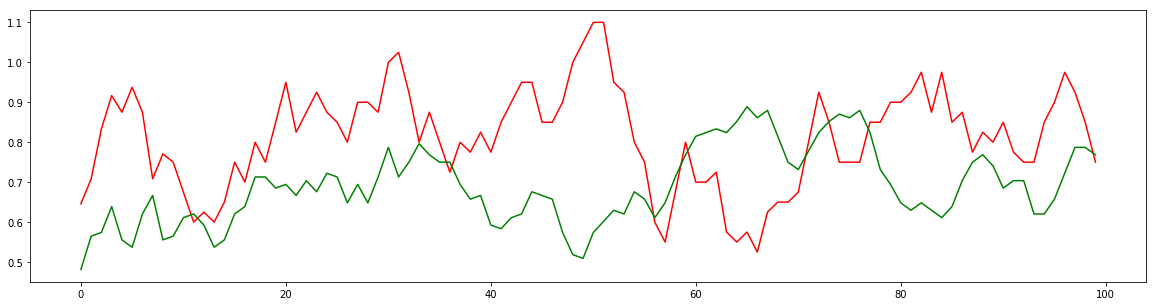

In [2]:
whoop = Traffic(100, 4, 8, 12, 5/100, 0.3, 0.3, 2/100, 0.0, 100, "Multi", 1, 1)
fig12 = plt.figure(figsize=(20,5))
ax12 = fig12.add_subplot(111)
#ax12.plot(whoop[2::3,6], 'bo')
ax12.plot(whoop[2::3,7], "r")
ax12.plot(whoop[2::3,8], "g")

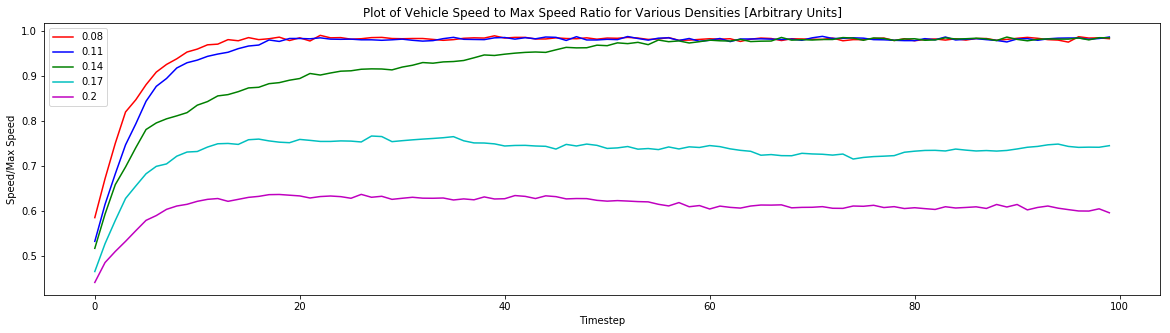

In [3]:
fig12 = plt.figure(figsize=(20,5))
ax12 = fig12.add_subplot(111)
index = 0
max_iters=50
timesteps = 50
labels=[]
for i in range(8, 21, 3):
    labels.append(i/100)
    average=np.zeros(timesteps)
    iters = 0
    while iters in range(max_iters):
        functioncall =Traffic(100, 0, 5, 0, i/100, 0.0, 0.0, 10/100, 0.0, timesteps, 1, 1, 1)[:,3]
        average += functioncall
        iters+=1
    average /= max_iters
    index+=1
    if index == 1:
        colour = "r"
    elif index == 2:
        colour = "b"

    elif index == 3:
        colour = "g"

    elif index == 4:
        colour = "c"

    elif index == 5:
        colour = "m"

    ax12.plot(average, colour)
    ax12.set_title("Plot of Vehicle Speed to Max Speed Ratio for Various Densities [Arbitrary Units]")
    ax12.set_xlabel("Timestep")
    ax12.set_ylabel("Speed/Max Speed")
    ax12.legend(labels)

look at density variations, dawdeling max speed/length of the road.

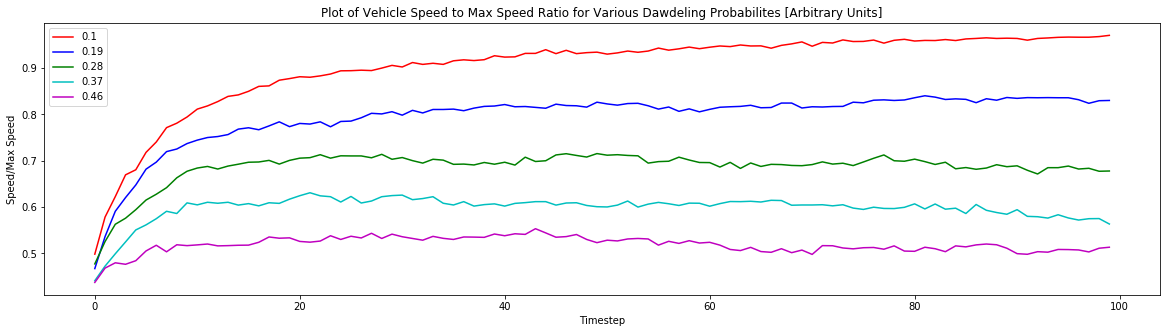

In [4]:
fig12 = plt.figure(figsize=(20,5))
ax12 = fig12.add_subplot(111)
index = 0
max_iters=50
timesteps = 50
labels=[]
for i in range(10, 51, 9):
    labels.append(i/100)
    average=np.zeros(timesteps)
    iters = 0
    while iters in range(max_iters):
        functioncall =Traffic(100, 0, 5, 0, 15/100, 0.0, 0.0, i/100, 0.0, timesteps, 1, 1, 1)[:,3]
        average += functioncall
        iters+=1
    average /= max_iters
    index+=1
    if index == 1:
        colour = "r"
    elif index == 2:
        colour = "b"

    elif index == 3:
        colour = "g"

    elif index == 4:
        colour = "c"

    elif index == 5:
        colour = "m"

    ax12.plot(average, colour)
    ax12.set_title("Plot of Vehicle Speed to Max Speed Ratio for Various Dawdeling Probabilites [Arbitrary Units]")
    ax12.set_xlabel("Timestep")
    ax12.set_ylabel("Speed/Max Speed")
    ax12.legend(labels)

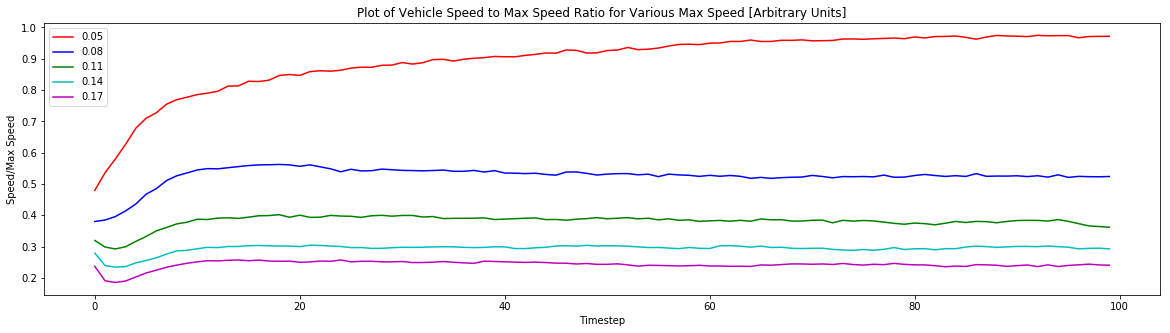

In [5]:
fig12 = plt.figure(figsize=(20,5))
ax12 = fig12.add_subplot(111)
index = 0
max_iters=50
timesteps = 50
labels=[]
for i in range(5, 20, 3):
    labels.append(i/100)
    average=np.zeros(timesteps)
    iters = 0
    while iters in range(max_iters):
        functioncall =Traffic(100, 0, i, 0, 15/100, 0.0, 0.0, 10/100, 0.0, timesteps, 1, 1, 1)[:,3]
        average += functioncall
        iters+=1
    average /= max_iters
    index+=1
    if index == 1:
        colour = "r"
    elif index == 2:
        colour = "b"

    elif index == 3:
        colour = "g"

    elif index == 4:
        colour = "c"

    elif index == 5:
        colour = "m"

    ax12.plot(average, colour)
    ax12.set_title("Plot of Vehicle Speed to Max Speed Ratio for Various Max Speed [Arbitrary Units]")
    ax12.set_xlabel("Timestep")
    ax12.set_ylabel("Speed/Max Speed")
    ax12.legend(labels)

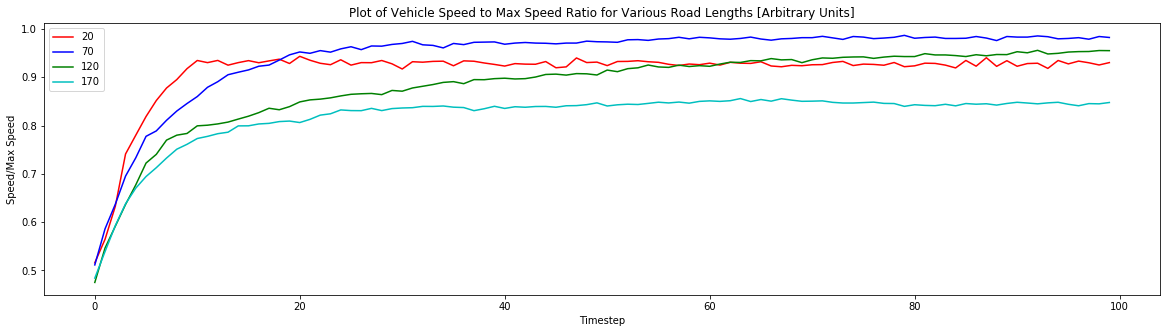

In [6]:
fig12 = plt.figure(figsize=(20,5))
ax12 = fig12.add_subplot(111)
index = 0
max_iters=50
timesteps = 50
labels=[]
for i in range(20, 200, 50):
    labels.append(i)
    average=np.zeros(timesteps)
    iters = 0
    while iters in range(max_iters):
        functioncall =Traffic(i, 0, 5, 0, 15/100, 0.0, 0.0, 10/100, 0.0, timesteps, 1, 1, 1)[:,3]
        average += functioncall
        iters+=1
    average /= max_iters
    index+=1
    if index == 1:
        colour = "r"
    elif index == 2:
        colour = "b"

    elif index == 3:
        colour = "g"

    elif index == 4:
        colour = "c"

    elif index == 5:
        colour = "m"

    ax12.plot(average, colour)
    ax12.set_title("Plot of Vehicle Speed to Max Speed Ratio for Various Road Lengths [Arbitrary Units]")
    ax12.set_xlabel("Timestep")
    ax12.set_ylabel("Speed/Max Speed")
    ax12.legend(labels)

In [ ]:
scipy.optimize.minimize()